# Use W5E5 v2.0 and daily mass-balance (with MBsandbox)

**What changed compared to last version**
- you can use now `run_constant_climate_TIModel` for the spinup instead of `run_random_climate_TIModel` (see code below in cell 10)

**What is new?**
- use variable lapse rates ('var_an_cycle') and W5E5 climate
- we can use daily temperature and precipitation input data:
    - can get daily specific_mb
    - works with run_with_climate_data and get daily resolution of volume
    - works with run_with_hydro, but it updates only monthly at the moment and the runoff output is monthly or annual
    
> need to install MBsandbox: https://github.com/OGGM/massbalance-sandbox 


In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import scipy
import scipy.stats as stats
import os
import oggm
from oggm import cfg, utils, workflow, tasks, graphics, entity_task
from oggm.core import massbalance, flowline, climate
from oggm.utils import (floatyear_to_date, date_to_floatyear)

# just for the graphics
SMALL_SIZE = 18
MEDIUM_SIZE = 20
BIGGER_SIZE = 24

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


# import the MSsandbox modules
from MBsandbox.mbmod_daily_oneflowline import process_w5e5_data, process_era5_daily_data, TIModel, BASENAMES
# from MBsandbox.help_func import compute_stat, minimize_bias, optimize_std_quot_brentq
from MBsandbox.help_func import minimize_bias_geodetic, optimize_std_quot_brentq_geod, melt_f_calib_geod_prep_inversion
from MBsandbox.flowline_TIModel import (run_from_climate_data_TIModel, run_constant_climate_TIModel,
                                        run_random_climate_TIModel)
cfg.initialize()
cfg.PARAMS['use_multiprocessing'] = True
cfg.PARAMS['continue_on_error'] = False

working_dir = utils.gettempdir(dirname='OGGM_hydro', reset=False)

cfg.PATHS['working_dir'] = working_dir
# use elevation band  flowlines
base_url = ('https://cluster.klima.uni-bremen.de/~oggm/gdirs/oggm_v1.4/'
            'L1-L2_files/elev_bands')

# as we calibrate to geodetic estimates we use calendar years!  
# need to check if this works in southern hemisphere
cfg.PARAMS['hydro_month_nh'] = 1





2023-04-11 14:30:19: oggm.cfg: Reading default parameters from the OGGM `params.cfg` configuration file.
2023-04-11 14:30:19: oggm.cfg: Multiprocessing switched OFF according to the parameter file.
2023-04-11 14:30:19: oggm.cfg: Multiprocessing: using all available processors (N=8)
2023-04-11 14:30:19: oggm.cfg: Multiprocessing switched ON after user settings.


In [2]:
# get the geodetic calibration data
# short test:
# check how many glaciers have geodetic msm
pd_geodetic = utils.get_geodetic_mb_dataframe()
ref_period = '2000-01-01_2020-01-01'
pd_geodetic = pd_geodetic.loc[pd_geodetic['period'] == ref_period]
area_geod_11 = pd_geodetic[pd_geodetic.reg == 11].loc[pd_geodetic[pd_geodetic.reg == 11].dmdtda.dropna().index].area.sum()
area_all_11 = pd_geodetic[pd_geodetic.reg == 11].area.sum()
relative_area_11 = area_geod_11/area_all_11
relative_area_11
#in the new corrected geodetic dataset, there are no glaciers without geodetic estimates inside anymore!!!

2023-04-11 14:30:19: oggm.utils: /home/lilianschuster/OGGM/download_cache/cluster.klima.uni-bremen.de/~oggm/geodetic_ref_mb/hugonnet_2021_ds_rgi60_pergla_rates_10_20_worldwide_filled.hdf verified successfully.


1.0

In [3]:
df = ['RGI60-11.00890', 'RGI60-11.00897'] #, 'RGI60-14.16678']
#'RGI60-14.08183',#'RGI60-14.02796',] # list of glaciers -> can be longer ... 
# this has to be done just once for a region (basin) (independent of climate, mb_type, prcp-fac ... )
init = True
if init:
    gdirs = workflow.init_glacier_directories(df, from_prepro_level=2,
                                              prepro_border=160, # 40, needed for the spinup
                                              prepro_base_url=base_url,
                                              prepro_rgi_version='62')
    workflow.execute_entity_task(tasks.compute_downstream_line, gdirs)
    workflow.execute_entity_task(tasks.compute_downstream_bedshape, gdirs)
else:
    gdirs = workflow.init_glacier_directories(df)

2023-04-11 14:30:20: oggm.workflow: init_glacier_directories from prepro level 2 on 2 glaciers.
2023-04-11 14:30:20: oggm.workflow: Execute entity tasks [gdir_from_prepro] on 2 glaciers
2023-04-11 14:30:23: oggm.utils: /home/lilianschuster/OGGM/download_cache/cluster.klima.uni-bremen.de/~oggm/gdirs/oggm_v1.4/L1-L2_files/elev_bands/RGI62/b_160/L2/RGI60-11/RGI60-11.00.tar verified successfully.
2023-04-11 14:30:24: oggm.workflow: Execute entity tasks [compute_downstream_line] on 2 glaciers
2023-04-11 14:30:24: oggm.core.centerlines: (RGI60-11.00897) compute_downstream_line
2023-04-11 14:30:24: oggm.core.centerlines: (RGI60-11.00890) compute_downstream_line
2023-04-11 14:30:25: oggm.workflow: Execute entity tasks [compute_downstream_bedshape] on 2 glaciers
2023-04-11 14:30:25: oggm.core.centerlines: (RGI60-11.00897) compute_downstream_bedshape
2023-04-11 14:30:25: oggm.core.centerlines: (RGI60-11.00890) compute_downstream_bedshape
2023-04-11 14:30:29: MBsandbox.mbmod_daily_oneflowline: (R

### things that can be changed before calibration


In [6]:
# if you have a precipitation factor from the hydrological model you can change it here
pf = 2  # we set the precipitation factor here to 1
climate_type = 'W5E5' 
mb_type = 'mb_real_daily' #real daily input, this would be monthly input:'mb_monthly' #'mb_real_daily' # 'mb_monthly'#
grad_type ='cte' # variable lapse rates



### melt_f calibration and inversion with glen-a calibration

In [7]:
# this has to be done once for each climate, mb_type, grad_type, pf option,
# then you can save the melt_f and a-factor for the runs later on 

if climate_type =='W5E5' or climate_type == 'W5E5_MSWEP':
    ye=2020 # till end of 2019
else:
    ye=2019
calib=True
if calib:

    if mb_type == 'mb_real_daily':
        temporal_resol = 'daily'
    else:
        temporal_resol = 'monthly'
        
    # get the climate data (either w5e5 or WFDE5_CRU)
    workflow.execute_entity_task(process_w5e5_data, gdirs,
                                 temporal_resol=temporal_resol, climate_type=climate_type)
 
    # calibrate melt_f and get apparent mb
    workflow.execute_entity_task(melt_f_calib_geod_prep_inversion, gdirs, 
                                 pf = pf, # precipitation factor
                                 mb_type=mb_type, grad_type=grad_type,
                                 climate_type=climate_type, residual=0,
                                 ye=ye)

    # here glen-a is calibrated to match gdirs glaciers in total
    border = 80
    filter = border >= 20
    pd_inv_melt_f = oggm.workflow.calibrate_inversion_from_consensus(gdirs,
                                                          apply_fs_on_mismatch=False,
                                                          error_on_mismatch=False,
                                                          filter_inversion_output=filter)
    workflow.execute_entity_task(tasks.init_present_time_glacier, gdirs)


    a_factor = gdirs[0].get_diagnostics()['inversion_glen_a'] / cfg.PARAMS['inversion_glen_a'] 
    # just a check if a-factor is set to the same value
    np.testing.assert_allclose(a_factor, gdirs[-1].get_diagnostics()['inversion_glen_a'] / cfg.PARAMS['inversion_glen_a'])


    # double check: volume sum of gdirs from Farinotti estimate is equal to oggm estimates
    np.testing.assert_allclose(pd_inv_melt_f.sum()['vol_itmix_m3'], pd_inv_melt_f.sum()['vol_oggm_m3'], rtol = 5e-2)
    
    # we use the json now and don't need a csv file 
    # old!
    #pd_inv_melt_f['melt_f_opt']= pd_inv_melt_f.index.map(melt_f_dict)  # different for each glacier
    #pd_inv_melt_f['pf'] = pf #  everywhere the same
    #pd_inv_melt_f.to_csv('test_calib_params_{}_{}_{}.csv'.format(climate_type, mb_type, grad_type))

2023-04-11 14:30:47: oggm.workflow: Execute entity tasks [process_w5e5_data] on 2 glaciers
2023-04-11 14:30:59: oggm.workflow: Execute entity tasks [melt_f_calib_geod_prep_inversion] on 2 glaciers
2023-04-11 14:31:00: oggm.workflow: Applying global task calibrate_inversion_from_consensus on 2 glaciers
2023-04-11 14:31:00: oggm.workflow: Consensus estimate optimisation with A factor: 0.1 and fs: 0
2023-04-11 14:31:00: oggm.workflow: Applying global task inversion_tasks on 2 glaciers
2023-04-11 14:31:00: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 2 glaciers
2023-04-11 14:31:00: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 2 glaciers
2023-04-11 14:31:00: oggm.workflow: Execute entity tasks [filter_inversion_output] on 2 glaciers
2023-04-11 14:31:00: oggm.workflow: Execute entity tasks [get_inversion_volume] on 2 glaciers
2023-04-11 14:31:00: oggm.workflow: Consensus estimate optimisation with A factor: 10.0 and fs: 0
2023-04-11 14:31:00: oggm.wo

In [8]:
mbdf = gdirs[1].get_ref_mb_data(input_filesuffix='_{}_{}'.format(temporal_resol, climate_type))['ANNUAL_BALANCE']
mb_glaciological = mbdf#['ANNUAL_BALANCE']
np.shape(mb_glaciological)

(41,)

In [9]:
type(mb_glaciological)

pandas.core.series.Series

#### like that we can access the calibrated melt_f (and prcp-fac)

In [10]:
fs = '_{}_{}_{}'.format(climate_type, mb_type, grad_type)
gdir = gdirs[-1]
gdir.read_json(filename='melt_f_geod', filesuffix=fs)

{'melt_f_pf_2': 218.80818624075468, 'ref_hgt_calib_diff': 0}

In [11]:
fs1 = '_{}_{}'.format(temporal_resol, climate_type)

ds = xr.open_dataset(gdir.get_filepath('climate_historical', filesuffix=fs1))
ds.ref_hgt - ds.uncorrected_ref_hgt 

0.0

## check if daily_hydro works

In [28]:
# Hydro outputs needs the full model geometry
cfg.PARAMS['store_model_geometry'] = True

2023-04-11 14:42:07: oggm.cfg: PARAMS['store_model_geometry'] changed from `False` to `True`.


In [32]:
ye = 2020
from MBsandbox.flowline_TIModel import run_with_hydro_daily
workflow.execute_entity_task(run_with_hydro_daily, gdirs,
                             run_task=run_from_climate_data_TIModel,
                            Testing = True,
                            ys=1980, ye=2020,
                            store_monthly_step= False,
                            output_filesuffix='_daily_1980_{}_{}_{}'.format(ye, mb_type, grad_type),
                            # kwargs for TIModel
                             mb_model_sub_class=TIModel,
                             bias=0, # only tested with bias=0 !!!, don't change!
                             mb_type=mb_type,
                             grad_type=grad_type,
                             precipitation_factor=pf, melt_f='from_json',
                             climate_input_filesuffix=climate_type);

2023-04-11 14:42:38: oggm.workflow: Execute entity tasks [run_with_hydro_daily] on 2 glaciers


In [33]:
ds_runoff = utils.compile_run_output(gdirs, input_filesuffix='_daily_1980_{}_{}_{}'.format(ye, mb_type, grad_type))

2023-04-11 14:42:45: oggm.utils: Applying global task compile_run_output on 2 glaciers
2023-04-11 14:42:45: oggm.utils: Applying compile_run_output on 2 gdirs.


In [34]:
ds_runoff

<xarray.Dataset>
Dimensions:                     (time: 41, rgi_id: 2, day_2d: 366)
Coordinates:
  * time                        (time) float64 1.98e+03 1.981e+03 ... 2.02e+03
  * rgi_id                      (rgi_id) <U14 'RGI60-11.00890' 'RGI60-11.00897'
    hydro_year                  (time) int64 1980 1981 1982 ... 2018 2019 2020
    hydro_month                 (time) int64 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1
    calendar_year               (time) int64 1980 1981 1982 ... 2018 2019 2020
    calendar_month              (time) int64 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1
  * day_2d                      (day_2d) int64 1 2 3 4 5 ... 362 363 364 365 366
    calendar_day_2d             (day_2d) int64 1 2 3 4 5 ... 362 363 364 365 366
Data variables: (12/26)
    volume                      (time, rgi_id) float64 5.39e+06 ... 3.032e+08
    volume_m3_min_h             (time, rgi_id) float64 5.39e+06 ... 3.03e+08
    volume_bsl                  (time, rgi_id) float64 0.0 0.0 0.0 ... 0.0 0.0
    volume_bwl                  (time, rgi_id) float64 0.0 0.0 0.0 ... 0.0 0.0
    area                        (time, rgi_id) float64 2.65e+05 ... 7.3e+06
    area_m2_min_h               (time, rgi_id) float64 2.65e+05 ... 7.253e+06
    ...                          ...
    liq_prcp_on_glacier_daily   (time, day_2d, rgi_id) float64 0.0 0.0 ... nan
    snowfall_off_glacier_daily  (time, day_2d, rgi_id) float64 2.592e+04 ... nan
    snowfall_on_glacier_daily   (time, day_2d, rgi_id) float64 2.023e+05 ... nan
    water_level                 (rgi_id) float64 0.0 0.0
    glen_a                      (rgi_id) float64 7.614e-24 7.614e-24
    fs                          (rgi_id) float64 0.0 0.0
Attributes:
    description:    OGGM model output
    oggm_version:   1.5.4.dev60+g9d17303
    calendar:       365-day no leap
    creation_date:  2023-04-11 12:42:45

###  just look at volume changes starting from rgi_date

2023-04-11 14:42:48: oggm.workflow: Execute entity tasks [run_from_climate_data_TIModel] on 2 glaciers
2023-04-11 14:42:48: oggm.utils: Applying global task compile_run_output on 2 glaciers
2023-04-11 14:42:48: oggm.utils: Applying compile_run_output on 2 gdirs.


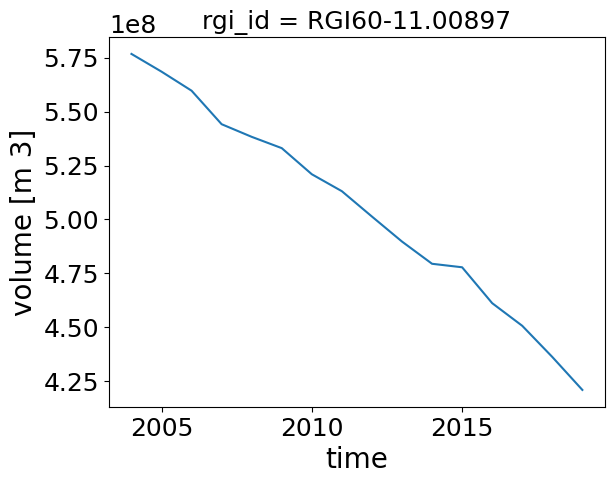

In [35]:

y0=2004
ye_h = ye-1   
# inside of run_from_climate_data_TIModel the calibrated melt_f is chosen from the melt_f_file csv file, such as:
# melt_f = pd_inv_melt_f['melt_f_opt'].loc[gdir.rgi_id]
# assert np.all(pf==pd_inv_melt_f['pf'])
workflow.execute_entity_task(run_from_climate_data_TIModel, gdirs, bias=0, #will actually point to the residual, should always be zero! 
                                  mb_model_sub_class=TIModel,
                                  min_ys=y0, ye=ye_h,
                                  mb_type=mb_type,
                                  grad_type=grad_type,
                                  precipitation_factor=pf, 
                                  melt_f='from_json', #melt_f_file=melt_f_file, # need to set these to find the right calibrated melt_f
                                  climate_input_filesuffix=climate_type,
                                  output_filesuffix='_{}_{}_{}'.format(climate_type, mb_type, grad_type) # can add here more options to distinguish between runs
                                 )
ds_vol = utils.compile_run_output(gdirs, input_filesuffix='_{}_{}_{}'.format(climate_type, mb_type, grad_type))
ds_vol.sel(rgi_id=df[-1]).volume.plot()
# without hydro here

### similar to hydro_tutorial, but values for HEF are quite different, 
- https://oggm.org/tutorials/stable/notebooks/hydrological_output.html
    - maybe need to check other prcp-fac
    - could also come from different initialisation! (in the tutorial, default a-factor was used, so different starting volume used here ...)
    

In [36]:
# ds = ds_runoff.sel(rgi_id=df[-1])
workflow.execute_entity_task(tasks.run_with_hydro, gdirs,
                             run_task=run_random_climate_TIModel,
                             store_monthly_hydro=True,
                             nyears=100,
                             temperature_bias=0,
                             y0=2014, # if WFDE5_CRU need to set y0=2013 because no data for 2019
                             halfsize=5, seed=0, 
                             unique_samples=True,
                             store_monthly_step=False,
                             mb_elev_feedback='annual',
                             output_filesuffix='_random_spinup_test',
                             bias=0,  # only tested with bias=0 !!!, don't change!
                             mb_type=mb_type,
                             grad_type=grad_type,
                             precipitation_factor=pf, 
                             melt_f='from_json', #melt_f_file=melt_f_file, # need to set these to find the right calibrated melt_f
                             climate_input_filesuffix=climate_type,
                             )
ds_runoff = utils.compile_run_output(gdirs, input_filesuffix='_random_spinup_test')
#could also use with xr.open_dataset(gdir.get_filepath('model_diagnostics', filesuffix='_random_spinup')) as ds:
# but the method above aggregates all glaciers

# The last step of hydrological output is NaN (we can't compute it for this year)
ds= ds_runoff.sel(rgi_id=df[-1]).isel(time=slice(0, -1)).load()
ds = ds.drop_vars('rgi_id')
ds = ds.isel(time=slice(0, -1)).load()


2023-04-11 14:43:04: oggm.workflow: Execute entity tasks [run_with_hydro] on 2 glaciers
2023-04-11 14:43:06: oggm.utils: Applying global task compile_run_output on 2 glaciers
2023-04-11 14:43:06: oggm.utils: Applying compile_run_output on 2 gdirs.


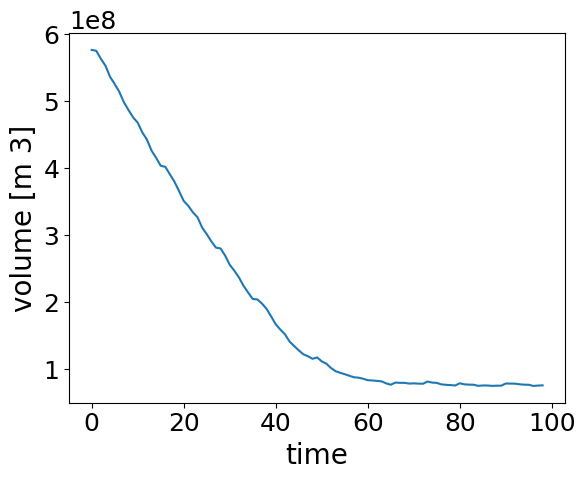

In [37]:
ds.volume.plot()
# the glacier will be almost gone in that climate 

In [38]:
# now the same using constant climate --> with run_task: run_constant_climate_TIModel, but don't need `seed` and `unique samples`
workflow.execute_entity_task(tasks.run_with_hydro, gdirs,
                             run_task=run_constant_climate_TIModel, #run_random_climate_TIModel
                             store_monthly_hydro=True,
                             nyears=100,
                             temperature_bias=0,
                             y0=2014, # if WFDE5_CRU need to set y0=2013 because no data for 2019
                             halfsize=5, #seed=0, 
                             store_monthly_step=False,
                             mb_elev_feedback='annual',
                             output_filesuffix='_random_spinup_test',
                             bias=0,  # only tested with bias=0 !!!, don't change!
                             mb_type=mb_type,
                             grad_type=grad_type,
                             precipitation_factor=pf, 
                             melt_f='from_json', #melt_f_file=melt_f_file, # need to set these to find the right calibrated melt_f
                             climate_input_filesuffix=climate_type,
                             )
ds_runoff = utils.compile_run_output(gdirs, input_filesuffix='_random_spinup_test')
#could also use with xr.open_dataset(gdir.get_filepath('model_diagnostics', filesuffix='_random_spinup')) as ds:
# but the method above aggregates all glaciers

# The last step of hydrological output is NaN (we can't compute it for this year)
ds= ds_runoff.sel(rgi_id=df[-1]).isel(time=slice(0, -1)).load()
ds = ds.drop_vars('rgi_id')
ds = ds.isel(time=slice(0, -1)).load()


2023-04-11 14:43:10: oggm.workflow: Execute entity tasks [run_with_hydro] on 2 glaciers
2023-04-11 14:43:13: oggm.utils: Applying global task compile_run_output on 2 glaciers
2023-04-11 14:43:13: oggm.utils: Applying compile_run_output on 2 gdirs.


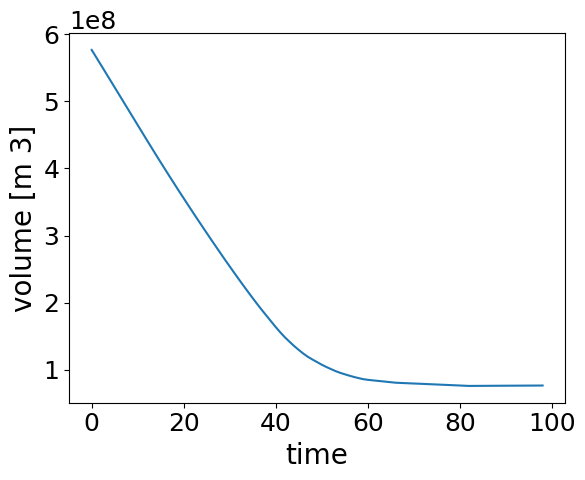

In [39]:
ds.volume.plot()
# the glacier will be almost gone in that climate 

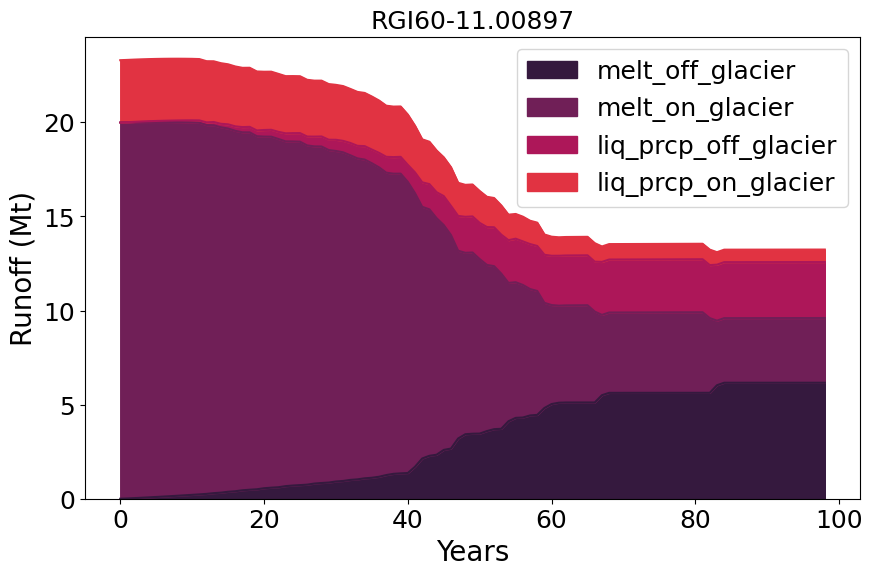

In [40]:
sel_vars = [v for v in ds.variables if 'month_2d' not in ds[v].dims]
df_annual = ds[sel_vars].to_dataframe()
# Select only the runoff variables and convert them to megatonnes (instead of kg)
runoff_vars = ['melt_off_glacier', 'melt_on_glacier', 'liq_prcp_off_glacier', 'liq_prcp_on_glacier']
df_runoff = df_annual[runoff_vars] * 1e-9

f, ax = plt.subplots(figsize=(10, 6));
df_runoff.plot.area(ax=ax, color=sns.color_palette("rocket")); #, stacked=False
plt.xlabel('Years'); plt.ylabel('Runoff (Mt)'); plt.title(gdir.rgi_id);


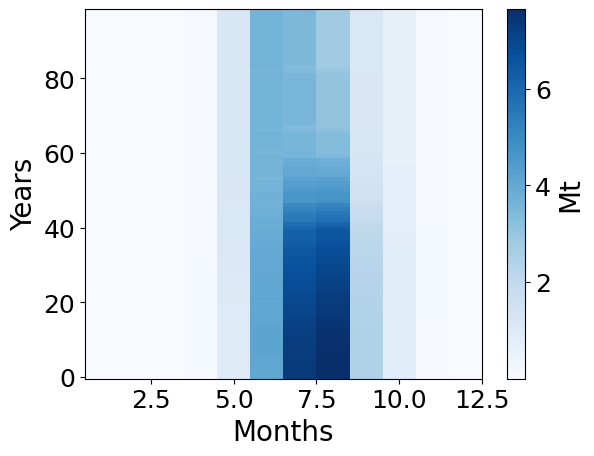

In [41]:
ds_roll = ds.roll(month_2d=ds['calendar_month_2d'].data[0]-1, roll_coords=True)
ds_roll['month_2d'] = ds_roll['calendar_month_2d']

# Select only the runoff variables and convert them to megatonnes (instead of kg)
monthly_runoff = ds_roll['melt_off_glacier_monthly'] + ds_roll['melt_on_glacier_monthly'] + ds_roll['liq_prcp_off_glacier_monthly'] + ds_roll['liq_prcp_on_glacier_monthly'] 
monthly_runoff *= 1e-9
monthly_runoff.clip(0).plot(cmap='Blues', cbar_kwargs={'label':'Mt'}); plt.xlabel('Months'); plt.ylabel('Years');

In [42]:
# Pick the variables we need (the 2d ones)
sel_vars = [v for v in ds_roll.variables if 'month_2d' in ds_roll[v].dims]

# Pick the first decade and average it
df_m_s = ds_roll[sel_vars].isel(time=slice(0, 10)).mean(dim='time').to_dataframe() * 1e-9
# Rename the columns for readability
df_m_s.columns = [c.replace('_monthly', '') for c in df_m_s.columns]
# Because of floating point precision sometimes runoff can be slightly below zero, clip
df_m_s = df_m_s.clip(0)

# Same for end
df_m_e = ds_roll[sel_vars].isel(time=slice(-11, -1)).mean(dim='time').to_dataframe() * 1e-9
df_m_e.columns = [c.replace('_monthly', '') for c in df_m_s.columns]
df_m_e = df_m_e.clip(0)


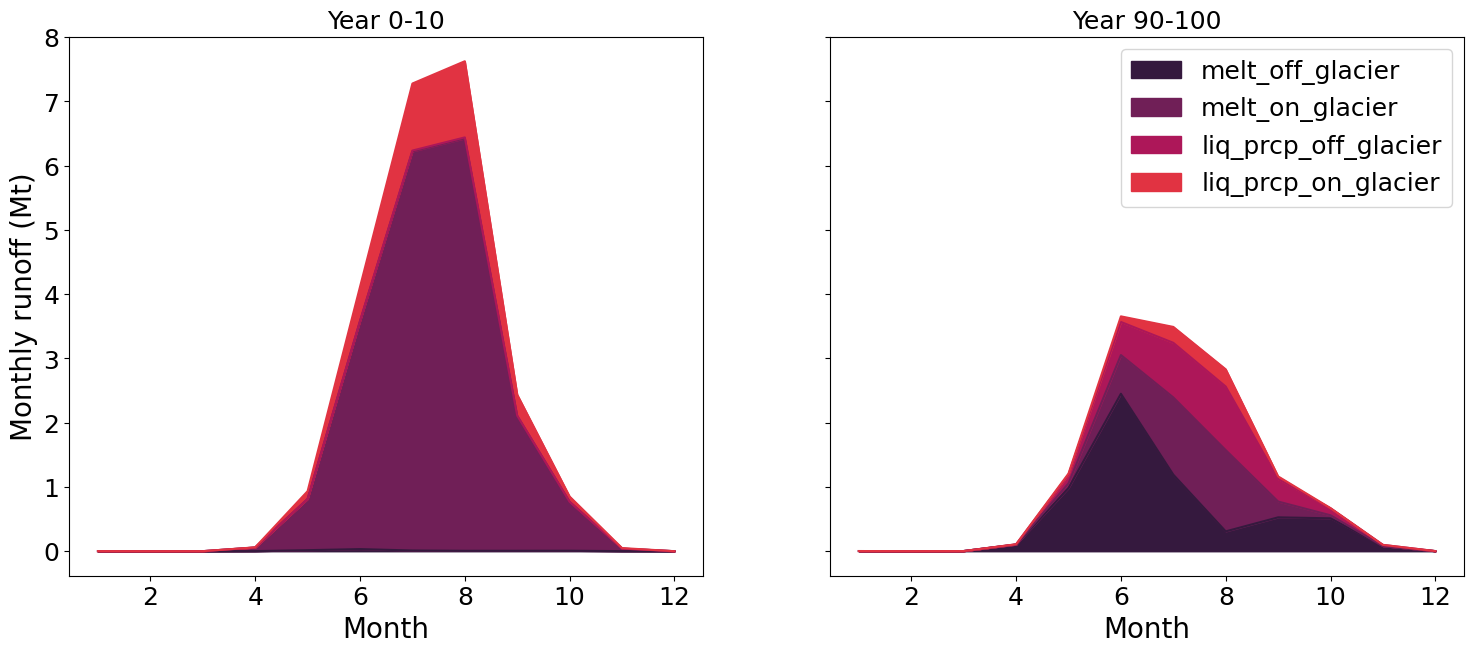

In [43]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7), sharey=True);
df_m_s[runoff_vars].plot.area(ax=ax1, legend=False, title='Year 0-10', color=sns.color_palette("rocket"));
df_m_e[runoff_vars].plot.area(ax=ax2, title='Year 90-100', color=sns.color_palette("rocket"));
ax1.set_ylabel('Monthly runoff (Mt)'); ax1.set_xlabel('Month'); ax2.set_xlabel('Month');

# now do the workflow of Sarah: 
- repeat the spinup again:
    - I use here a smaller halfsize and add a negative temperature bias

In [44]:
temp_bias = -0.2
# temp_bias for W5E5_MSWEP (with MSWEP prcp, and prcp-fac of 1) needs to be higher than for W5E5 (with prcp-fac of 2)
# you can change this and see how it influences the glacier volume

In [45]:
workflow.execute_entity_task(tasks.run_with_hydro, gdirs, 
                             run_task=run_random_climate_TIModel,
                        store_monthly_hydro=True,
                        nyears=500,
                        y0=1984, halfsize=5,
                        seed=0, 
                        temperature_bias=temp_bias,
                        unique_samples=True,
                        store_monthly_step=False,
                        mb_elev_feedback='annual',
                        output_filesuffix='_random_spinup',
                        bias=0,  # only tested with bias=0 !!!, don't change!
                        mb_type=mb_type,
                        grad_type=grad_type,
                        precipitation_factor=pf, melt_f='from_json',
                        climate_input_filesuffix=climate_type,
                        )

2023-04-11 14:43:16: oggm.workflow: Execute entity tasks [run_with_hydro] on 2 glaciers


[None, None]

2023-04-11 14:43:24: oggm.utils: Applying global task compile_run_output on 2 glaciers
2023-04-11 14:43:24: oggm.utils: Applying compile_run_output on 2 gdirs.


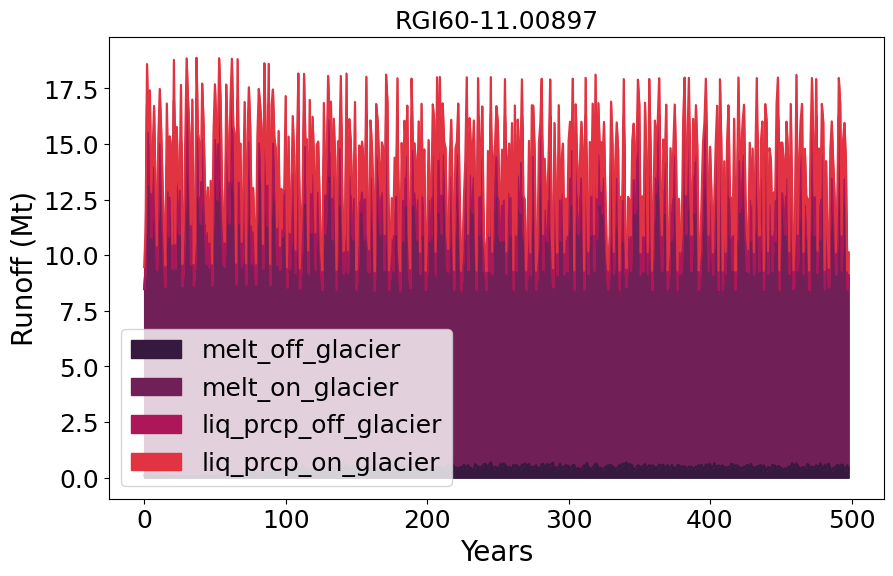

In [46]:

with xr.open_dataset(gdir.get_filepath('model_diagnostics', filesuffix='_random_spinup')) as ds:
    # The last step of hydrological output is NaN (we can't compute it for this year)
    ds = ds.isel(time=slice(0, -1)).load()
ds_runoff = utils.compile_run_output(gdirs, input_filesuffix='_random_spinup')

# The last step of hydrological output is NaN (we can't compute it for this year)
ds= ds_runoff.sel(rgi_id=df[-1]).isel(time=slice(0, -1)).load()
ds = ds.drop_vars('rgi_id')
ds = ds.isel(time=slice(0, -1)).load()


sel_vars = [v for v in ds.variables if 'month_2d' not in ds[v].dims]
df_annual = ds[sel_vars].to_dataframe()
# Select only the runoff variables and convert them to megatonnes (instead of kg)
runoff_vars = ['melt_off_glacier', 'melt_on_glacier', 'liq_prcp_off_glacier', 'liq_prcp_on_glacier']
df_runoff = df_annual[runoff_vars] * 1e-9

f, ax = plt.subplots(figsize=(10, 6));
df_runoff.plot.area(ax=ax, color=sns.color_palette("rocket")); #, stacked=False
plt.xlabel('Years'); plt.ylabel('Runoff (Mt)'); plt.title(gdir.rgi_id);


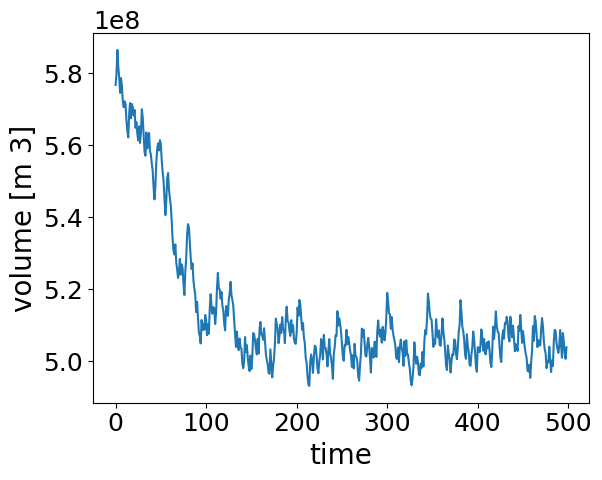

In [47]:
ds.volume.plot()
# the glacier will be almost gone if no temp_bias
# want that glacier volume is higher than the inversion volume (at point 0)

# run the climate 

2023-04-11 14:44:44: oggm.workflow: Execute entity tasks [run_with_hydro] on 2 glaciers
2023-04-11 14:44:45: oggm.utils: Applying global task compile_run_output on 2 glaciers
2023-04-11 14:44:45: oggm.utils: Applying compile_run_output on 2 gdirs.


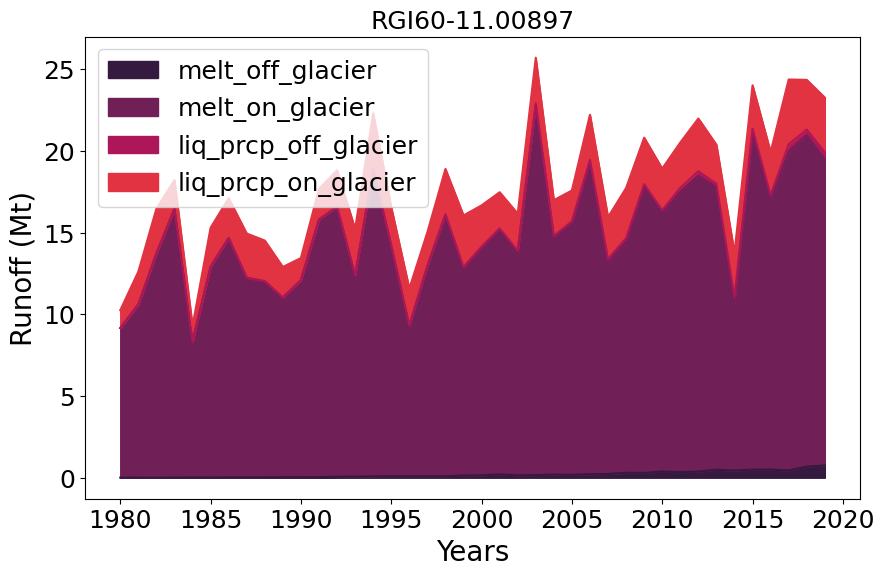

In [49]:
workflow.execute_entity_task(tasks.run_with_hydro, gdirs, 
                             run_task=run_from_climate_data_TIModel, store_monthly_hydro = True,
                    ys=1980, ye=ye,
                    init_model_filesuffix='_random_spinup', # if you want to apply the spinup need to add here the right filesuffix !!!!!!!!!!!!!!!!
                    store_monthly_step= False,
                    output_filesuffix='_1980_{}_{}_{}'.format(ye, mb_type, grad_type),
                    # kwargs for TIModel 
                     mb_model_sub_class=TIModel,
                     bias=0, # only tested with bias=0 !!!, don't change!
                     mb_type=mb_type,
                     grad_type=grad_type,
                     precipitation_factor=pf, melt_f='from_json',
                     climate_input_filesuffix=climate_type,
                    )
ds_runoff = utils.compile_run_output(gdirs, input_filesuffix='_1980_{}_{}_{}'.format(ye, mb_type, grad_type))

# only select HEF   
ds = ds_runoff.sel(rgi_id = df[-1])
ds = ds.drop_vars('rgi_id')

# The last step of hydrological output is NaN (we can't compute it for this year)
ds = ds.isel(time=slice(0, -1)).load()
sel_vars = [v for v in ds.variables if 'month_2d' not in ds[v].dims]
df_annual = ds[sel_vars].to_dataframe()
# Select only the runoff variables and convert them to megatonnes (instead of kg)
runoff_vars = ['melt_off_glacier', 'melt_on_glacier', 'liq_prcp_off_glacier', 'liq_prcp_on_glacier']
df_runoff = df_annual[runoff_vars] * 1e-9

f, ax = plt.subplots(figsize=(10, 6));
df_runoff.plot.area(ax=ax, color=sns.color_palette("rocket")); #, stacked=False
plt.xlabel('Years'); plt.ylabel('Runoff (Mt)'); plt.title(gdir.rgi_id);


- does this make sense that runoff rather increases, because peak water has been reached at some time between 2010 and 2020 ??? 

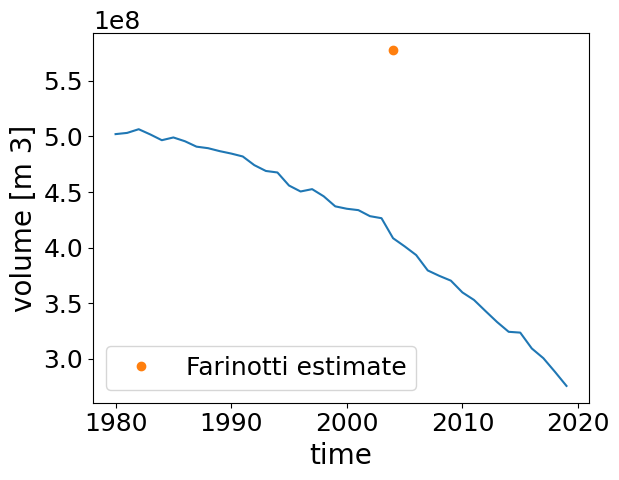

In [50]:
ds.volume.plot()
ds.sel(time=2004).volume
# volume estimate of Farinotti 
plt.plot(2004, pd_inv_melt_f.loc[gdir.rgi_id].vol_itmix_m3, 'o', label='Farinotti estimate')
plt.legend()

- depending on which prcp-fac, the spin-up is not sufficient and we could apply a negative temp. bias because initial volume in 1980 should be well above the rgi_date,
    - need to find a valid temp_bias that results in the right volume in 2004 (this depends on prcp_fac, mb_type, grad_type)
        - e.g. if W5E5, prcp_fac =2, mb_type = 'mb_real_daily', and grad_type = 'var_an_cycle' -> temp_bias during spin up needs to be at around -0.7°C
        - but if WFDE5_CRU, prcp_fac=1, rest the same -> temp_bias around -0.4°C